In [23]:
import jupyter_black

jupyter_black.load()

In [24]:
from qlearning import QLearner
from grid_world import PickUpAndDeliver
import pandas as pd
import numpy as np

In [25]:
def reward(current_state, previous_state):
    position, damage, pickup = current_state
    _, previous_damage, _ = previous_state

    if damage == 5:
        return np.array([-25, -25])
    if position == 22 and pickup == True:
        return np.array([50, 50])
    if previous_damage < damage:
        return np.array([-1, -10])
    else:
        return np.array([-1, 0])


def update_state(state, actor_pos):
    terminal = False
    _, damage, pickup = state
    damage_pos = [0, 1, 11, 12, 16, 18, 23, 25, 30, 36, 39]
    if actor_pos in damage_pos:
        damage += 1
    if actor_pos == 19:
        pickup = True
    if (actor_pos == 22 and pickup) or damage == 5:
        terminal = True
    return (actor_pos, damage, pickup), terminal


def env():
    height = 6
    width = 7
    inital_state = (22, 0, False)
    return PickUpAndDeliver(inital_state, reward, update_state, 22, height, width)

In [26]:
def qlearner(
    learning_rate=0.1,
    discount_factor=0.9,
    explore_rate=0.01,
    weight_function=lambda x: x[0],
    objective=0,
):
    learner = QLearner(
        ["up", "down", "right", "left"],
        learning_rate,
        discount_factor,
        explore_rate,
        objectives=2,
        weight_function=weight_function,
    )
    episodes = list()
    for episode in range(1, 10000):
        totalValue = 0
        actions = list()
        world = env()
        learner.start_episode(world.current_state())

        end = False
        while end != True:
            action = learner.act(world.current_state())
            actions.append(action)
            value, end = world.act(action)
            totalValue += value[objective]
            learner.reward(value, world.current_state())

        learner.end_episode()
        episodes.append((episode, totalValue, actions))
    return learner, episodes


def episodes_to_df(
    episodes, columns=["episode", "total value", "actions"]
) -> pd.DataFrame:
    return pd.DataFrame(episodes, columns=columns)


def print_actions(episodes):
    for episode, totalValue, actions in episodes:
        print(
            "Episode: {}, total value: {}, actions: {}".format(
                episode, totalValue, actions
            )
        )

In [27]:
q1, q1_episodes = qlearner(explore_rate=0.01)
q1_df = episodes_to_df(q1_episodes)

q2, q2_episodes = qlearner(
    weight_function=lambda x: x[1], explore_rate=0.01, objective=1
)
q2_df = episodes_to_df(q2_episodes)

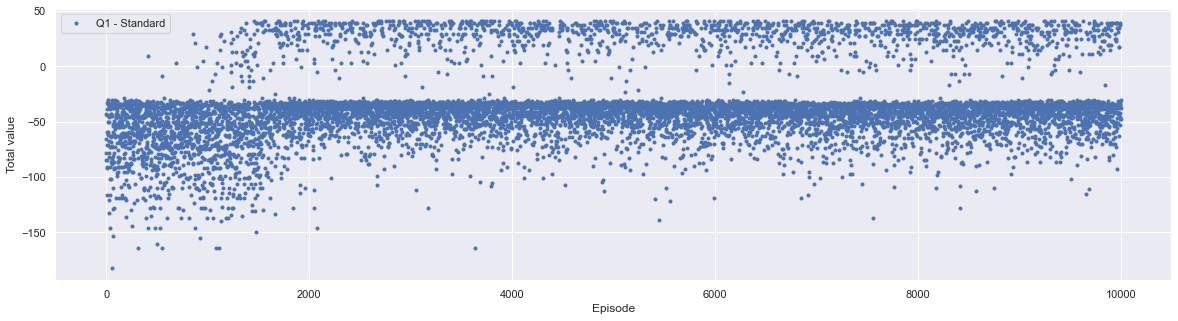

In [28]:
from matplotlib import pyplot

pyplot.figure(figsize=(20, 5))
pyplot.plot(range(1, 10000), q1_df["total value"], "b.")
pyplot.ylabel("Total value")
pyplot.xlabel("Episode")
pyplot.legend(["Q1 - Standard"])
pyplot.show()

In [29]:
q1_df

,episode,total value,actions
0,1,-66,"[right, up, up, up, up, down, down, up, up, do..."
1,2,-85,"[up, up, up, up, down, left, up, up, down, up,..."
2,3,-78,"[left, up, up, up, up, down, down, down, up, u..."
3,4,-43,"[down, up, right, up, down, up, up, up, up, left]"
4,5,-44,"[up, down, down, left, up, down, down, up, rig..."
...,...,...,...
9994,9995,37,"[right, right, right, right, down, up, up, rig..."
9995,9996,-46,"[right, right, down, right, right, left, up, l..."
9996,9997,-38,"[right, up, right, right, right, left, left, u..."
9997,9998,-48,"[right, down, right, right, right, down, up, l..."


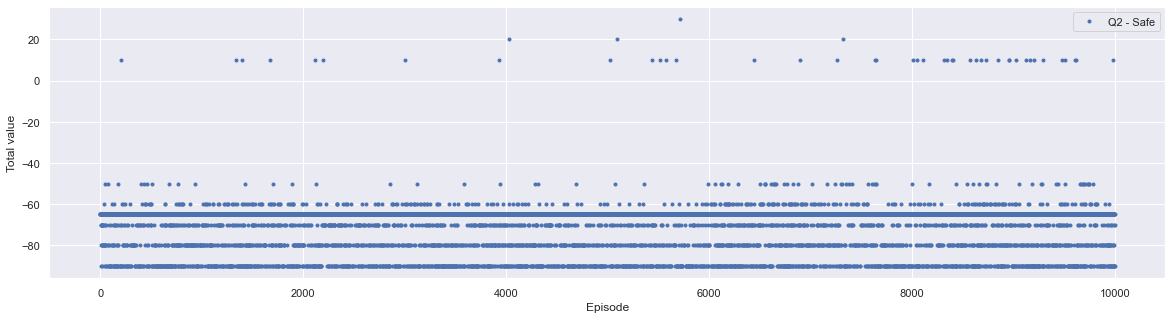

In [30]:
from matplotlib import pyplot

pyplot.figure(figsize=(20, 5))
pyplot.plot(range(1, 10000), q2_df["total value"], "b.")
pyplot.ylabel("Total value")
pyplot.xlabel("Episode")
pyplot.legend(["Q2 - Safe"])
pyplot.show()

In [31]:
q2_df

,episode,total value,actions
0,1,-65,"[up, right, left, left, right, up, up, up, up,..."
1,2,-65,"[down, up, up, left, right, up, up, up, up, up..."
2,3,-65,"[up, up, right, up, up, up, up, up, up, up, up..."
3,4,-65,"[up, right, right, up, left, right, up, up, up..."
4,5,-90,"[up, up, up, up, up, up, down, down, down, up,..."
...,...,...,...
9994,9995,-90,"[down, up, down, up, down, up, down, down, dow..."
9995,9996,-65,"[up, down, down, right, up, up, right, left, u..."
9996,9997,-90,"[left, down, right, up, right, left, left, lef..."
9997,9998,-70,"[down, up, left, down, right, down, down, down..."


In [32]:
np.max(q2_df["total value"])

30

In [33]:
def create_state_value(
    q_table,
    height=6,
    width=7,
    weight_function=lambda x: x[0],
):
    state_values = list()
    for i in range(5):
        before_pickup = [0] * width * height
        after_pickup = [0] * width * height
        for ((position, damage, pickup), v) in q_table.items():
            if damage == i:
                if pickup == False:
                    before_pickup[position] = np.average(list(map(weight_function, v)))
                else:
                    after_pickup[position] = np.average(list(map(weight_function, v)))
        state_values.append((before_pickup, after_pickup))
    return state_values

In [34]:
state_values = create_state_value(q1.Q)
state_values[0][0]

[0,
 0,
 -0.14695441033872192,
 -2.9549031235946424,
 -3.0010332903282024,
 -2.377574642442271,
 -2.02454562113342,
 4.291464571364413,
 10.79720033855627,
 6.432144186869571,
 0.5283520434531193,
 0,
 0,
 -0.5066862255846123,
 8.187992979582823,
 12.134267758744791,
 0,
 -1.6999985217171374,
 0,
 0,
 -0.62447554225,
 7.14326766818146,
 11.03675343355415,
 0,
 -1.0136096225310356,
 0,
 -0.05,
 -0.34975,
 5.181098551000768,
 8.92024207725261,
 0,
 -0.3850271533257599,
 -0.10745208029101203,
 -0.1,
 -0.325,
 -0.8789389798855142,
 0,
 -0.352788632758065,
 -0.37427499999999997,
 0,
 -0.025,
 -0.025]

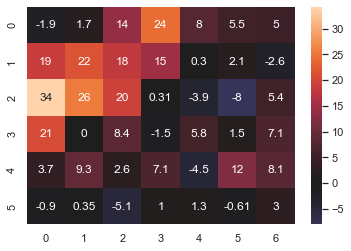

In [35]:
import seaborn as sns

sns.set_theme()
arr = state_values[4][1]
arr = np.reshape(arr, (6, 7))
ax = sns.heatmap(arr, center=0, annot=True)

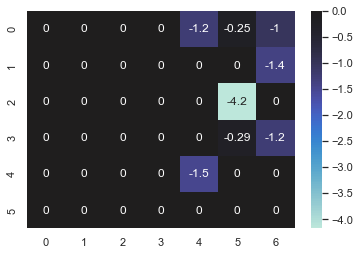

In [36]:
state_values_q2 = create_state_value(q2.Q, weight_function=lambda x: x[1])
arr_q2 = state_values_q2[0][1]
arr_q2 = np.reshape(arr_q2, (6, 7))
ax = sns.heatmap(arr_q2, center=0, annot=True)